[Chapter 7] Portfolio Construction

In [9]:
import numpy as np
import pandas as pd

from scipy.linalg import block_diag
from sklearn.utils import check_random_state

import matplotlib.pyplot as plt
import seaborn as sns

import import_ipynb
from ch4 import getRndBlockCov, randomBlockCorr, cov2corr

measurement and source of convariance instability

3.0


<Axes: >

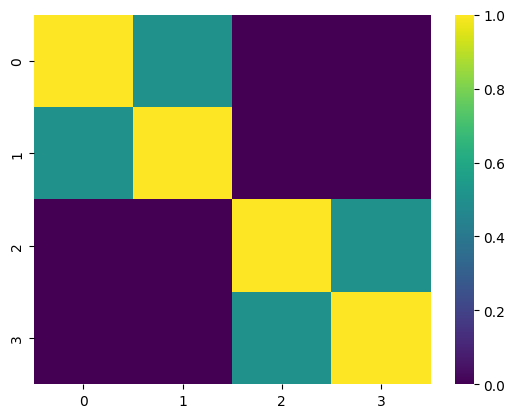

In [27]:
def formBlockMatrix(nBlocks, BlockSize, intracorr=0.5):

    # block with intrablock correlation = intracorr
    block = np.full((BlockSize, BlockSize), intracorr)
    np.fill_diagonal(block, 1)
    
    # block matrix with interblock correlation = 0
    corr0 = block_diag(*([block] * nBlocks))  
    
    return corr0

# example
corr0 = formBlockMatrix(2, 2, 0.5)
#[[1.  0.5 0.  0. ]
# [0.5 1.  0.  0. ]
# [0.  0.  1.  0.5]
# [0.  0.  0.5 1. ]]

eVal, eVec = np.linalg.eigh(corr0)
# condition number
# the bigger one eigenvalue becomes relative to the other (i.e. the greater the condition number)
#   the more |C| approaches zero (=>inv(C) or inv(V) to explode, for which w* depends on) 
#   the more unstable for optimization
print (max(eVal) / min(eVal))

# visualization                                
sns.heatmap(corr0, cmap='viridis')

4.000000000000002


<Axes: >

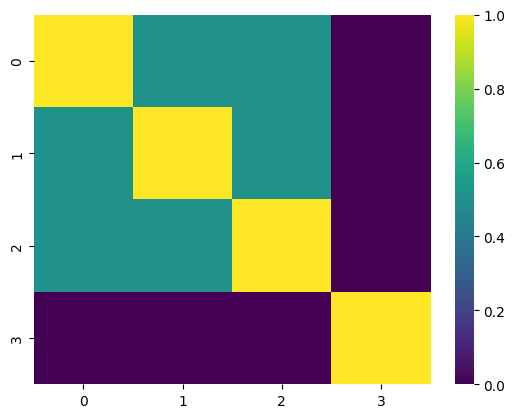

In [28]:
# the condition number rises if
 
# 1) make one block greater/bigger 
# the greater the N/T ratio (noise grows with N_nCol/T_nObs), the greater the condition number
corr0 = block_diag(formBlockMatrix(1, 3, 0.5),formBlockMatrix(1, 1, 0.5))
eVal, eVec = np.linalg.eigh(corr0)
print (max(eVal) / min(eVal))                  
sns.heatmap(corr0, cmap='viridis')

7.0


<Axes: >

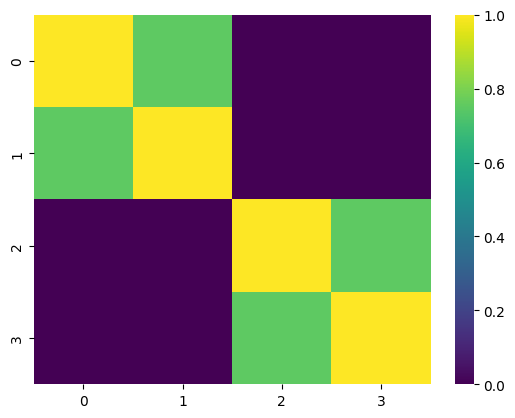

In [29]:
# 2) increase the intrablock correlation
# the greater the intracluster correlation, the greater the condition number
corr0 = formBlockMatrix(2, 2, 0.75)
eVal, eVec = np.linalg.eigh(corr0)
print (max(eVal) / min(eVal))                  
sns.heatmap(corr0, cmap='viridis')

3.0


<Axes: >

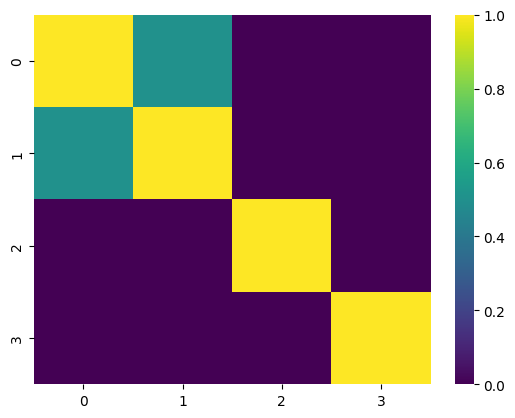

In [31]:
# bring down the intrablock correlation in only one of the two blocks 
#   does not reduce the condition number given the extreme eigen values are caused by dominant block
corr0 = block_diag(formBlockMatrix(1, 2, 0.5),formBlockMatrix(1, 2, 0.0))
eVal, eVec = np.linalg.eigh(corr0)
print (max(eVal) / min(eVal))      # condition number is still 3.0             
sns.heatmap(corr0, cmap='viridis')

# Implication: the instability of markowitz's solution can be traced back to a few dominant clusters
#               we can contain the instability by optimizing the dominant clusters separately

nested clustered optimization algorithm